Experiments:

19540 - initial experiment without feeding parameters, only lasted till around 1000 iterations.

39352 - restore parameters, make predictions upto 5 timesteps instead of 3

Both are wrong, thanks to switching around min train and max train values in the training loop

In [1]:
# do data cleaning and create appropriate dataloaders
# to exhaustively cover the entire training dataset. 
# build PC regression module to perform sparse regression
# between the parameter-timestep combinations and the initial
# frames for "synthetic" data generation (i.e. don't pass test
# images directly)

# also create some plotting utils to appropriately process and
# save the images, with correct ticklabels.

In [2]:
import torch
import torch.nn 
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.data import Sampler
from torch.utils.data import random_split
import pandas as pd
import numpy as np
import os
import re
import sys
import logging
import torchvision
import torchvision.transforms as T
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

/home/ajivani/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/ajivani/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
args = {
    # "niters": 1000,
    "niters": 600,
    # "niters":150,
    "lr": 1e-3,
    "save": "experiments/",
    "save_figs": "prediction_figs/",
    "load": None,
    "r": 1991,
    "node-layers": 2,
    "mlp-layers": 1,
    "latents": 8,  # 68818 has 8 latent dims
    "units": 50,
    "resize_dims": (16, 64),
    "param_scaling": [1, 1],
    "warm_start": 20376,
    "do_warm_start": False,
    "quadratic": False,
    # "loss": "smooth_l1",
    "loss": "mae",
    # "loss": "hybrid", # combine mae and ssim
    "batch_size": 4,
    "steps_to_predict": 8,
    "sampled_ics": 4,
    "dropout":False
}

In [4]:
import torch
import torch.nn 
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.data import random_split
import pandas as pd
import numpy as np
import os
import re
import sys
import logging
import torchvision
import torchvision.transforms as T
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

import node_utils as nut
import data_utils as dut

import time
import datetime
import argparse
import copy
import numpy as np
# import pandas as pd
from random import SystemRandom

from rich.progress import track
import tqdm

adjoint=True
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

from sunpy.visualization import colormaps as cm

lc3_reg = cm.cmlist['soholasco3']
lc3 = cm.cmlist['soholasco3'].reversed()

import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt

plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
cme_params_scaled = pd.read_csv("./old_data_surrogate/CMEParams2161_Scaled.csv")
# cme_params_scaled.head()

# rename unnamed column to SimID
cme_params_scaled = cme_params_scaled.rename(columns={'Unnamed: 0': 'SimID'})
# cme_params_scaled = cme_params_scaled.loc[:, ~cme_params_scaled.columns.str.contains('^Unnamed')]
cme_params_scaled.head()

,SimID,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0,0.5675,0.420040,0.568916,0.5525,1.0,0.272727,0.120833,0.098542,0.436506
1,1,0.4525,0.057350,0.348039,0.1025,1.0,0.272727,0.120833,0.098542,0.436506
2,2,0.8525,0.014777,0.541725,0.8775,1.0,0.272727,0.120833,0.098542,0.436506
3,3,0.1225,0.323231,0.214567,0.5075,0.0,0.272727,0.120833,0.098542,0.436506
4,4,0.7825,0.085414,0.640815,0.3325,1.0,0.272727,0.120833,0.098542,0.436506


In [6]:
# Load IDs to keep amongst successful runs (1-indexed!)
ids_to_keep_raw = np.load("./old_data_surrogate/ids_to_keep_2161.npy")
ids_to_keep = ids_to_keep_raw - 1
ids_to_keep.shape

(254,)

In [7]:
successful_sim_ids = cme_params_scaled['SimID'].to_numpy()

In [8]:
indices_to_keep = np.where(np.isin(successful_sim_ids, ids_to_keep))[0]

In [9]:
filtered_df = cme_params_scaled[cme_params_scaled['SimID'].isin(ids_to_keep)]

In [10]:
cme_params_np = filtered_df.iloc[:, 1:].to_numpy()

In [11]:
raw_images = np.load("./old_data_surrogate/CR2161_tDecay2h_Polar_Compressed.npy")

In [12]:
raw_images_to_keep = raw_images[:62, :, :, indices_to_keep]
raw_min, raw_max = raw_images_to_keep.min(), raw_images_to_keep.max()

In [13]:
num_sim = len(indices_to_keep)
data_sim_ids = np.linspace(0, num_sim - 1, num_sim, dtype=int)

generator1 = torch.Generator().manual_seed(2024)
train_frac, val_frac, test_frac = 0.7, 0.1, 0.2
train_valid_test = random_split(data_sim_ids,
                                [train_frac, val_frac, test_frac],
                                # [train_size, valid_size, test_size],
                                generator=generator1)

train_idx = np.array(train_valid_test[0].indices)
val_idx = np.array(train_valid_test[1].indices)
test_idx = np.array(train_valid_test[2].indices)

ntrain = train_idx.shape[0]
nval = val_idx.shape[0]
ntest = test_idx.shape[0]
ntrain, nval, ntest

(178, 26, 50)

In [14]:
train_data_raw = raw_images_to_keep[:, :, :, train_idx]
val_data_raw = raw_images_to_keep[:, :, :, val_idx]
test_data_raw = raw_images_to_keep[:, :, :, test_idx]

In [15]:
resize_dims = args["resize_dims"]

train_data_resized = T.Resize(size=resize_dims,
                                  antialias=True
                                  )(torch.Tensor(train_data_raw.transpose(3, 2, 0, 1)))

val_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(val_data_raw.transpose(3, 2, 0, 1)))

test_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(test_data_raw.transpose(3, 2, 0, 1)))

In [16]:
max_train = torch.max(train_data_resized)
min_train = torch.min(train_data_resized)

max_train, min_train

(tensor(1.5000), tensor(0.9356))

In [17]:
# all_timesteps = np.linspace(2, 182, 90, dtype=int) # adding extra timestep to accomodate the last observation.

tt_og = np.linspace(2, 180, 90, dtype=int)
tt_og_ts = np.linspace(0, 1, 90)

tMinIdxSim = 50
tMaxIdxSim = len(tt_og) - 1

print(tMinIdxSim, tMaxIdxSim)

tstartSim = tt_og_ts[tMinIdxSim]
tendSim = tt_og_ts[tMaxIdxSim]
nTimesteps_sim = tMaxIdxSim - tMinIdxSim + 1
tt_predictSim = np.linspace(tstartSim, tendSim, nTimesteps_sim)
tt_predictSim = torch.Tensor(tt_predictSim).to(device)

nTimesteps_sim, tt_predictSim

50 89


(40,
 tensor([0.5618, 0.5730, 0.5843, 0.5955, 0.6067, 0.6180, 0.6292, 0.6404, 0.6517,
         0.6629, 0.6742, 0.6854, 0.6966, 0.7079, 0.7191, 0.7303, 0.7416, 0.7528,
         0.7640, 0.7753, 0.7865, 0.7978, 0.8090, 0.8202, 0.8315, 0.8427, 0.8539,
         0.8652, 0.8764, 0.8876, 0.8989, 0.9101, 0.9213, 0.9326, 0.9438, 0.9551,
         0.9663, 0.9775, 0.9888, 1.0000]))

In [18]:
tt_predictSim.shape

torch.Size([40])

In [19]:
train_data = (train_data_resized[:, tMinIdxSim:(tMaxIdxSim + 1), :, :] - min_train)/(max_train - min_train)
val_data = (val_data_resized[:, tMinIdxSim:(tMaxIdxSim + 1), :, :] - min_train)/(max_train - min_train)
test_data = (test_data_resized[:, tMinIdxSim:(tMaxIdxSim + 1), :, :] - min_train)/(max_train - min_train)

In [20]:
train_data.min(), val_data.min(), test_data.min()

(tensor(0.), tensor(0.0217), tensor(0.0107))

In [21]:
train_params_raw = cme_params_np[train_idx, :]
valid_params_raw = cme_params_np[val_idx, :]
test_params_raw = cme_params_np[test_idx, :]

In [22]:
expanded_tpredict_train = tt_predictSim.view(1, nTimesteps_sim, 1).expand(ntrain, nTimesteps_sim, -1)
expanded_tpredict_val = tt_predictSim.view(1, nTimesteps_sim, 1).expand(nval, nTimesteps_sim, -1)
expanded_tpredict_test = tt_predictSim.view(1, nTimesteps_sim, 1).expand(ntest, nTimesteps_sim, -1)

expanded_tpredict_train.shape

torch.Size([178, 40, 1])

In [23]:
train_snaps = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
val_snaps = val_data.reshape((val_data.shape[0], val_data.shape[1], -1))
test_snaps = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

# reshape tpredict to be the same dimensions as train snaps etc.

train_snaps_concat = torch.cat((train_snaps, expanded_tpredict_train), 2)
val_snaps_concat = torch.cat((val_snaps, expanded_tpredict_val), 2)
test_snaps_concat = torch.cat((test_snaps, expanded_tpredict_test), 2)

# repeat parameter values up to number of timesteps
train_params_ts = np.repeat(train_params_raw.reshape((train_params_raw.shape[0], train_params_raw.shape[1], 1)), nTimesteps_sim, axis=2)
val_params_ts = np.repeat(valid_params_raw.reshape((valid_params_raw.shape[0], valid_params_raw.shape[1], 1)), nTimesteps_sim, axis=2)
test_params_ts = np.repeat(test_params_raw.reshape((test_params_raw.shape[0], test_params_raw.shape[1], 1)), nTimesteps_sim, axis=2)

# concatenate snaps and params
train_all = torch.cat((train_snaps_concat, torch.Tensor(np.transpose(train_params_ts, (0, 2, 1)))), 2)
val_all = torch.cat((val_snaps_concat, torch.Tensor(np.transpose(val_params_ts, (0, 2, 1)))), 2)
test_all = torch.cat((test_snaps_concat, torch.Tensor(np.transpose(test_params_ts, (0, 2, 1)))), 2)

In [24]:
train_params_raw.shape

(178, 9)

In [25]:
train_all.shape, val_all.shape, test_all.shape

(torch.Size([178, 40, 1034]),
 torch.Size([26, 40, 1034]),
 torch.Size([50, 40, 1034]))

In [26]:
# train_dataset = []
# val_dataset = []

# we will predict the full time series for test dataset starting from the 
# initial condition only, without any intermediate sampling.

test_dataset = []
# for i in range(ntrain):
#     for j in range(1, nTimesteps_sim - 1):
#         train_dataset.append((train_all[i:(i+1), (j-1), :], train_all[i:(i+1), (j-1):(j+2), :], tt_predictSim[(j-1):(j+2)]))

# for i in range(nval):
#     for j in range(1, nTimesteps_sim - 1):
#         val_dataset.append((val_all[i:(i+1), (j-1), :],
#                             val_all[i:(i+1), (j-1):(j+2), :],
#                             tt_predictSim[(j-1):(j+2)]))

for i in range(ntest):
        test_dataset.append((test_all[i:(i+1), 0, :],
                             test_all[i:(i+1), :, :],
                             tt_predictSim))
        
# test_dataset_ar = []
# for i in range(ntest):
#     for j in range(1, nTimesteps_sim - 1):
#         test_dataset_ar.append((test_all[i:(i+1), (j-1), :],
#                             test_all[i:(i+1), (j-1):(j+2), :],
#                             tt_predictSim[(j-1):(j+2)]))

In [27]:
# tt_predictSim[(j-1):(j+2)]

In [28]:
# len(train_dataset)

In [29]:
6764/178

38.0

In [30]:
class SimulationDataset(Dataset):
    def __init__(self, all_data, tt_predictSim, nsims, nTimesteps_sim):
        """
        all_data - one of train_all, val_all, test_all
        nsims - one of ntrain, nval, nsim
        """
        self.data_all = all_data
        self.tt_predictSim = tt_predictSim
        self.ndata = nsims
        self.nTimesteps_sim = nTimesteps_sim
        # self.data_pairs = []

        # for j in range(1, nTimesteps_sim - 1):
        #     for i in range(nsims):
        #         # Append (i, j-1) to form data pairs for later lookup
        #         self.data_pairs.append((i, j-1))
    
    # def __len__(self):
    #     return len(self.data_pairs)
    
    def __len__(self):
        return self.ndata * (self.nTimesteps_sim - 4)
    
    def __getitem__(self, idx):
        # i, j_minus_1 = self.data_pairs[idx]
        # Retrieve data for (i, j-1)
        i, j_minus_1 = idx
        input_ = self.data_all[i:(i+1), j_minus_1, :]
        sequence_ = self.data_all[i:(i+1), j_minus_1:(j_minus_1+5), :]
        tt_sequence = self.tt_predictSim[j_minus_1:(j_minus_1+5)]
        
        return i, j_minus_1, input_, sequence_, tt_sequence

In [31]:
class ConsistentTimeWindowSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.batch_size = batch_size
        self.nTimesteps_sim = dataset.nTimesteps_sim
        self.ndata = dataset.ndata
        self.time_windows = list(range(0, self.nTimesteps_sim - 4))
        np.random.shuffle(self.time_windows)
        
    def __iter__(self):
        for time_idx in self.time_windows:
            sim_indices = np.random.choice(self.ndata, self.batch_size, replace=False)
            batch = [(sim_idx, time_idx) for sim_idx in sim_indices]
            yield batch
            
    def __len__(self):
        return len(self.time_windows) * (self.ndata // self.batch_size)

In [32]:
train_dataset = SimulationDataset(train_all, tt_predictSim, ntrain, nTimesteps_sim)
train_sampler = ConsistentTimeWindowSampler(train_dataset, batch_size = 8)
train_dataloader = DataLoader(train_dataset, batch_sampler=train_sampler)

val_dataset = SimulationDataset(val_all, tt_predictSim, nval, nTimesteps_sim)
val_sampler = ConsistentTimeWindowSampler(val_dataset, batch_size=8)
val_dataloader = DataLoader(val_dataset, batch_sampler=val_sampler)

# test_dataset = SimulationDataset(test_all, tt_predictSim, ntest, nTimesteps_sim)
# test_sampler = ConsistentTimeWindowSampler(test_dataset, batch_size = ntest)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [33]:
len(train_dataloader), len(val_dataloader)

(792, 108)

In [34]:
bleh = train_dataloader.__iter__().__next__()

In [35]:
# for i, b in enumerate(train_dataloader):
#     print(i, b[0], b[1], b[-1][0, :])

In [36]:
class ODENet(nn.Module):
    def __init__(self, 
                 latent_dim, 
                 param_dim,
                 device,
                 n_layers=2,
                 n_units=50,
                 n_units_q=100,
                 nonlinear=nn.ELU,
                 quadratic=False):
    
        super(ODENet, self).__init__()
        # layers = [nn.Linear(latent_dim + param_dim, n_units)]
        layers = [nn.Linear(latent_dim + param_dim,
                            n_units)]
        for i in range(n_layers - 1):
            layers.append(nonlinear())
            layers.append(nn.Linear(n_units, n_units))

        layers.append(nonlinear())
        layers.append(nn.Linear(n_units, latent_dim))  

        odenet = nn.Sequential(*layers)

        nut.init_network_weights_xavier_normal(odenet)

        self.odenet = odenet
        # self.odenet_q = odenet_q
        self.latent_dim = latent_dim
        self.quadratic = quadratic
        self.device = device

    def quadratic_y(self, y):
        pass

    def forward(self, t, y):
        output = torch.cat((self.odenet(y),
                    torch.zeros_like(y[:, :, self.latent_dim:])), 
                    -1)
        return output

In [37]:
class PNODE_Conv(nn.Module):
    def __init__(self, 
                 input_dim,
                 latent_dim,
                 param_dim,
                 device,
                 n_layers=2, 
                 n_units=50,
                 nonlinear=nn.ELU,
                 quadratic=False,
                 dropout=False,
                 resize_dims=(32, 128)):
        super(PNODE_Conv, self).__init__()
        
        if dropout==True:
            self.regularize = nn.Dropout(0.6)
        else:
            self.regularize = nn.Identity()
        
        self.resize_dims=resize_dims
        encoder = nn.Sequential(nn.ZeroPad2d((7,8,7,8)),
                        nn.Conv2d(1,4,16,stride=(2,2),padding=(0,0)),
                        nn.ELU(),
                        nn.ZeroPad2d((3,4,3,4)),
                        nn.Conv2d(4,8,8,stride=(2,2),padding=(0,0)),
                        nn.ELU(),
                        nn.ZeroPad2d((1,2,1,2)),
                        nn.Conv2d(8,16,4,stride=(2,2),padding=(0,0)),
                        nn.ELU(),
                        nn.ZeroPad2d((0,1,0,1)),
                        nn.Conv2d(16,32,2,stride=(2,2),padding=(0,0)),
                        nn.ELU(),
                        nn.ZeroPad2d((0,0,0,0)),
                        nn.Conv2d(32,64,1,stride=(2,2),padding=(0,0)),
                        nn.ELU(),
                        nn.Flatten(),
                        # nn.Linear(256,latent_dim),
                        nn.Linear(128, latent_dim),
                        nn.ELU(),
                        self.regularize) 
                
        decoder_mlp = nn.Sequential(nn.Linear(latent_dim, 128),
                                    # nn.Linear(latent_dim, 256),
                                    nn.ELU(),
                                   self.regularize)
        
        decoder_conv = nn.Sequential(nn.ConvTranspose2d(64,32,(4,4),stride=(2,2),padding=(1,1)),
            nn.ELU(),
            nn.ConvTranspose2d(32,16,(4,4),stride=(2,2),padding=(1,1)),
            nn.ELU(),
            nn.ConvTranspose2d(16,8,(8,8),stride=(2,2),padding=(3,3)),
            nn.ELU(),
            # nn.ConvTranspose2d(8,4,(16,16),stride=(2,2),padding=(7,7)),
            # nn.ELU(),
            # nn.ConvTranspose2d(4,1,(16,16),stride=(2,2),padding=(7,7)),
            # nn.ELU()
            )        
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        self.encoder=encoder
        self.pnode=ODENet(latent_dim, 
                          param_dim,
                          device,
                          n_layers=n_layers,
                          n_units=n_units,
                          quadratic=quadratic).to(device)
        
        if quadratic == True:
            print("Using lin-quad PNODE")
        else:
            print("Using regular PNODE")

        self.decoder_mlp = decoder_mlp
        self.decoder_conv = decoder_conv
        
        
        nut.init_network_weights_xavier_normal(self.encoder)
        nut.init_network_weights_xavier_normal(self.decoder_mlp)
        nut.init_network_weights_xavier_normal(self.decoder_conv)
        
        
    def forward(self, t, y):
        init_state = y[:, :, :self.input_dim]
        nbatch, ntraj, nseq = init_state.shape
        init_state = init_state.reshape((nbatch * ntraj, 1, self.resize_dims[0], self.resize_dims[1]))
        init_latent = self.encoder(init_state).reshape((nbatch, ntraj, self.latent_dim))
        init_latent = torch.cat((init_latent, y[:, :, self.input_dim:]),-1)
        latent_states = odeint(self.pnode, init_latent, t)
        ls_init = latent_states[:, :, :, :self.latent_dim]
        ntraj2, nbatch2, nseq2, _  = ls_init.shape
        latent_mlp = self.decoder_mlp(ls_init)
        decoder_features = latent_mlp.reshape((-1, 64, 1, 4))
        pred_sol = self.decoder_conv(decoder_features)
        pred_sol = pred_sol.reshape((ntraj2, nbatch2, nseq2, int(self.resize_dims[0] * self.resize_dims[1])))
        
        return pred_sol

In [38]:
input_dim = int(resize_dims[0] * resize_dims[1])
input_dim

1024

In [39]:
model = PNODE_Conv(input_dim=input_dim, 
                       latent_dim=args["latents"], 
                       param_dim=10, 
                       device=device,
                       n_layers=args["node-layers"],
                       n_units=args["units"],
                       quadratic=args["quadratic"],
                       dropout=args["dropout"],
                       resize_dims=args["resize_dims"]).to(device)

Using regular PNODE


In [40]:
pEncoder = nut.count_parameters(model.encoder)
pPNODE = nut.count_parameters(model.pnode)
pDecoder = nut.count_parameters(model.decoder_mlp) + nut.count_parameters(model.decoder_conv)

print("Total Number of Parameters: ")
print(pEncoder + pPNODE + pDecoder)

Total Number of Parameters: 
64640


In [41]:
# il1 = model.encoder(bleh[2][:, :, :1024].reshape(8, 1, 16, 64)).unsqueeze(1)
# il2 = torch.cat((il1, bleh[2][:, :, 1024:]), -1)
# il2.shape

In [42]:
# ls = odeint(model.pnode, il2, bleh[-1][0, :])

In [43]:
# bleh_pred = model(bleh[-1][0, :], bleh[2])
# bleh_pred.shape

In [44]:
# bleh_pred_rs = torch.permute(torch.squeeze(bleh_pred), (1, 0, 2)).reshape(8, 5, 16, 64)
# bleh_pred_rs.shape

In [45]:
# bleh[3].shape

In [46]:
# bleh_target = torch.squeeze(bleh[3][:, :, :, :input_dim]).reshape(8, 5, 16, 64)
# bleh_target.shape

In [47]:
nut.makedirs(os.path.join(os.getcwd(), "logs"))
logdir = os.path.join(os.getcwd(), "logs")

exptdir = os.path.join(os.getcwd(), args["save"])
nut.makedirs(exptdir)
# nut.makedirs("./model_stopping")

if args["load"] is not None:
    experimentID = args["load"]
    print("Loading experiment")
else:
    if args["do_warm_start"] == True:
        experimentID = args["warm_start"]
        print("Warm starting previous experiment")
    else:
        experimentID = int(SystemRandom().random()*100000)
        print("Starting new experiment")

print("Experiment ID: ")
print(experimentID)

ckpt_path = os.path.join(exptdir, "experiment_" + str(experimentID) + '.ckpt')

print("Checkpoint Path: ")
print(ckpt_path)

logger = dut.get_logger(logpath=os.path.join(logdir, "expt_normalized_pnode_images_2.log"))
logger

logger.info(os.getcwd())
logger.info(model)
logger.info("Number of parameters: {}".format(pEncoder + pPNODE + pDecoder))
logger.info(args)
logger.info("Checkpoint Path")
logger.info(ckpt_path)
logger.info("Input Dim: ")
logger.info(input_dim)
logger.info("Param Dim: ")
logger.info(10)
logger.info("Latent Dim: ")
logger.info(args["latents"])
logger.info(device)

/home/ajivani/WLROM_new/WhiteLight
PNODE_Conv(
  (regularize): Identity()
  (encoder): Sequential(
    (0): ZeroPad2d((7, 8, 7, 8))
    (1): Conv2d(1, 4, kernel_size=(16, 16), stride=(2, 2))
    (2): ELU(alpha=1.0)
    (3): ZeroPad2d((3, 4, 3, 4))
    (4): Conv2d(4, 8, kernel_size=(8, 8), stride=(2, 2))
    (5): ELU(alpha=1.0)
    (6): ZeroPad2d((1, 2, 1, 2))
    (7): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2))
    (8): ELU(alpha=1.0)
    (9): ZeroPad2d((0, 1, 0, 1))
    (10): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
    (11): ELU(alpha=1.0)
    (12): ZeroPad2d((0, 0, 0, 0))
    (13): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
    (14): ELU(alpha=1.0)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=128, out_features=8, bias=True)
    (17): ELU(alpha=1.0)
    (18): Identity()
  )
  (pnode): ODENet(
    (odenet): Sequential(
      (0): Linear(in_features=18, out_features=50, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=50

Starting new experiment
Experiment ID: 
11016
Checkpoint Path: 
/home/ajivani/WLROM_new/WhiteLight/experiments/experiment_11016.ckpt


In [48]:
args["niters"]

600

In [49]:
792 * 2

1584

In [50]:
max_train, min_train

(tensor(1.5000), tensor(0.9356))

In [51]:
# init_latent = torch.cat((init_latent, obs_data[:, :, input_dim:]),
#                         -1)

# latent_preds = odeint(model.pnode, init_latent, tpredict)

# all_init_latents.append(init_latent)
# all_init_preds.append(latent_preds)

In [52]:
optimizer = optim.Adamax(model.parameters(), lr=args["lr"])
val_loss_list = []
train_loss_list = []

num_batches = 1
early_stopping = nut.EarlyStopping(patience=40,
                                verbose=True,
                                path=ckpt_path)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       'min', 
                                                       factor=0.8, 
                                                       patience=40)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,
                                              # base_lr=0.000216,
                                              # max_lr=0.01)
ckpt_freq=10
trainMax = copy.deepcopy(max_train)
trainMin = copy.deepcopy(min_train)


if args["load"] is None:
    # This is us trying to warm start predictions.
    if args["do_warm_start"] == True:
        checkpoint = torch.load(ckpt_path)
        model.load_state_dict(checkpoint['model'])
        start_epoch = checkpoint['epoch']
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        print("Warm Starting Experiment {} from Epoch {}".format(experimentID, start_epoch))
    else:
        start_epoch = 0
        print("Starting a new experiment {} from Epoch {}".format(experimentID, start_epoch))
    
    # Resume training from a specific epoch
    for itr in track(range(start_epoch + 1, num_batches * (args["niters"] + 1)), description="Looping over Epochs..."):
    # for itr in track(range(start_epoch + 1, num_batches * (1600 + 1)), description="Looping over Epochs..."):
        model.train()
    # for itr in track(range(1, num_batches * (args["niters"] + 1)), description="Looping over Epochs..."):
        optimizer.zero_grad()
                
        # all_batch_dicts = dut.get_next_batch(dut.inf_generator(train_dataloader)
        for i, batch_dict in enumerate(train_dataloader):
            # print(batch_dict["observed_data"].shape)
            sim_idx, tidx, obs_data, data_to_predict, tp_predict = batch_dict[0], batch_dict[1], batch_dict[2], batch_dict[3], batch_dict[4]
            
            # raw_preds = torch.zeros(3, obs_data.shape[0], 1, input_dim).to(device)
            raw_preds = model(tp_predict[0, :], obs_data)
            
            # for jj in range(obs_data.shape[0]):
                # raw_pred = model(tp_predict[jj, :], obs_data)
                # raw_preds[:, jj, :, :] = raw_pred[:, jj, :, :]

            model_pred = torch.permute(torch.squeeze(raw_preds), (1, 0, 2)) * (trainMax - trainMin) + trainMin
            target = torch.squeeze(data_to_predict[:, :, :, :input_dim]) * (trainMax - trainMin) + trainMin

            # print(target.shape, model_pred.shape)

            train_loss = nut.oden_loss(target, model_pred, loss=args["loss"])

            train_loss.backward()
            optimizer.step()
            train_loss_list.append(train_loss.item())
            # scheduler.step()

        model.eval()
        
        for i, val_dict in enumerate(val_dataloader):
        # for val_dict in all_val_dicts:
            val_idx, val_t_idx, val_data, val_to_predict, tp_predict_val = val_dict[0], val_dict[1], val_dict[2], val_dict[3], val_dict[4]
            # raw_val_preds = torch.zeros(3, val_data.shape[0], 1, input_dim).to(device)
            # for jj in range(val_data.shape[0]):
                # raw_val_pred = model(tp_predict_val[jj, :], val_data)
                # raw_val_preds[:, jj, :, :] = raw_val_pred[:, jj, :, :]
                
            raw_val_preds = model(tp_predict_val[0, :], val_data)

            val_pred = torch.permute(torch.squeeze(raw_val_preds), (1, 0, 2)) * (trainMax - trainMin) + trainMin
            val_target = torch.squeeze(val_to_predict[:, :, :, :input_dim]) * (trainMax - trainMin) + trainMin

            val_loss = nut.oden_loss(val_target, val_pred, loss=args["loss"])
            
            
            val_loss_list.append(val_loss.item())

        message = 'Epoch {:04d}|Val loss {:.6e}|Train loss {:.6e}|LR {:.5f}|'.format(
                        itr//num_batches,
                        val_loss.item(), 
                        train_loss.item(), 
                        optimizer.param_groups[0]["lr"])

        logger.info(message)
        scheduler.step(val_loss)
        if itr % ckpt_freq == 0:
            early_stopping(val_loss, model, optimizer, itr, args)


        if early_stopping.early_stop:
            print('Early stopping')
            torch.save(model.state_dict(), os.path.join(args["save"], "experiment_" + str(experimentID) + '_early_stopping.ckpt'))
        #     break
        
else:
    # check if early stopping checkpoint exists, load that if the case.
    # early_stop_filepath = os.path.join(args["save"], "experiment_" + str(experimentID) + "_early_stopping.ckpt")
    # if os.path.exists(early_stop_filepath):
    #     early_stp_ckpt = torch.load(early_stop_filepath)
    #     model.load_state_dict(early_stp_ckpt)
    # else:
    nut.get_ckpt_model(ckpt_path, model, device)

Output()

Starting a new experiment 11016 from Epoch 0


Epoch 0001|Val loss 6.434749e-02|Train loss 4.596254e-02|LR 0.00100|
Epoch 0002|Val loss 3.772844e-02|Train loss 3.585529e-02|LR 0.00100|
Epoch 0003|Val loss 6.669937e-02|Train loss 3.925584e-02|LR 0.00100|
Epoch 0004|Val loss 4.126590e-02|Train loss 4.165686e-02|LR 0.00100|
Epoch 0005|Val loss 3.435113e-02|Train loss 2.670678e-02|LR 0.00100|
Epoch 0006|Val loss 2.890002e-02|Train loss 2.833816e-02|LR 0.00100|
Epoch 0007|Val loss 3.558626e-02|Train loss 2.642030e-02|LR 0.00100|
Epoch 0008|Val loss 3.395857e-02|Train loss 2.045296e-02|LR 0.00100|
Epoch 0009|Val loss 4.986687e-02|Train loss 2.029278e-02|LR 0.00100|
Epoch 0010|Val loss 3.563143e-02|Train loss 2.344532e-02|LR 0.00100|


Validation loss decreased (inf --> 0.04).  Saving model ...

Epoch 0011|Val loss 2.647392e-02|Train loss 2.519966e-02|LR 0.00100|
Epoch 0012|Val loss 3.186023e-02|Train loss 2.418716e-02|LR 0.00100|
Epoch 0013|Val loss 3.020091e-02|Train loss 2.211514e-02|LR 0.00100|
Epoch 0014|Val loss 2.605327e-02|Train loss 2.583086e-02|LR 0.00100|
Epoch 0015|Val loss 5.030265e-02|Train loss 2.910846e-02|LR 0.00100|
Epoch 0016|Val loss 3.459111e-02|Train loss 2.431666e-02|LR 0.00100|
Epoch 0017|Val loss 3.647304e-02|Train loss 3.335531e-02|LR 0.00100|
Epoch 0018|Val loss 2.429451e-02|Train loss 2.834741e-02|LR 0.00100|
Epoch 0019|Val loss 4.492458e-02|Train loss 2.930241e-02|LR 0.00100|
Epoch 0020|Val loss 3.403717e-02|Train loss 2.533867e-02|LR 0.00100|


Validation loss decreased (0.04 --> 0.03).  Saving model ...

Epoch 0021|Val loss 2.663131e-02|Train loss 2.069156e-02|LR 0.00100|
Epoch 0022|Val loss 3.016874e-02|Train loss 1.750659e-02|LR 0.00100|
Epoch 0023|Val loss 2.269168e-02|Train loss 2.302613e-02|LR 0.00100|
Epoch 0024|Val loss 2.880200e-02|Train loss 2.323688e-02|LR 0.00100|
Epoch 0025|Val loss 2.306373e-02|Train loss 2.220961e-02|LR 0.00100|
Epoch 0026|Val loss 2.603435e-02|Train loss 2.142299e-02|LR 0.00100|
Epoch 0027|Val loss 3.387316e-02|Train loss 2.383341e-02|LR 0.00100|
Epoch 0028|Val loss 1.938531e-02|Train loss 1.581613e-02|LR 0.00100|
Epoch 0029|Val loss 3.262369e-02|Train loss 2.075255e-02|LR 0.00100|
Epoch 0030|Val loss 2.991569e-02|Train loss 2.278005e-02|LR 0.00100|


Validation loss decreased (0.03 --> 0.03).  Saving model ...

Epoch 0031|Val loss 2.342023e-02|Train loss 2.168725e-02|LR 0.00100|
Epoch 0032|Val loss 2.805412e-02|Train loss 1.945365e-02|LR 0.00100|
Epoch 0033|Val loss 3.280986e-02|Train loss 2.650777e-02|LR 0.00100|
Epoch 0034|Val loss 3.810100e-02|Train loss 3.258137e-02|LR 0.00100|
Epoch 0035|Val loss 2.000627e-02|Train loss 2.514460e-02|LR 0.00100|
Epoch 0036|Val loss 3.792999e-02|Train loss 2.341162e-02|LR 0.00100|
Epoch 0037|Val loss 2.386225e-02|Train loss 1.809140e-02|LR 0.00100|
Epoch 0038|Val loss 2.713208e-02|Train loss 2.191457e-02|LR 0.00100|
Epoch 0039|Val loss 3.385531e-02|Train loss 2.341017e-02|LR 0.00100|
Epoch 0040|Val loss 3.306871e-02|Train loss 2.643635e-02|LR 0.00100|


EarlyStopping counter: 1 out of 40

Epoch 0041|Val loss 2.857835e-02|Train loss 2.084134e-02|LR 0.00100|
Epoch 0042|Val loss 3.458768e-02|Train loss 3.108212e-02|LR 0.00100|
Epoch 0043|Val loss 2.937289e-02|Train loss 2.658849e-02|LR 0.00100|
Epoch 0044|Val loss 2.620484e-02|Train loss 2.152586e-02|LR 0.00100|
Epoch 0045|Val loss 2.628848e-02|Train loss 2.255052e-02|LR 0.00100|
Epoch 0046|Val loss 3.159435e-02|Train loss 1.738707e-02|LR 0.00100|
Epoch 0047|Val loss 2.090952e-02|Train loss 2.206141e-02|LR 0.00100|
Epoch 0048|Val loss 2.425443e-02|Train loss 1.771661e-02|LR 0.00100|
Epoch 0049|Val loss 2.273918e-02|Train loss 2.369514e-02|LR 0.00100|
Epoch 0050|Val loss 3.199299e-02|Train loss 2.471322e-02|LR 0.00100|


EarlyStopping counter: 2 out of 40

Epoch 0051|Val loss 3.313267e-02|Train loss 1.932859e-02|LR 0.00100|
Epoch 0052|Val loss 3.455822e-02|Train loss 1.824083e-02|LR 0.00100|
Epoch 0053|Val loss 2.490704e-02|Train loss 2.033944e-02|LR 0.00100|
Epoch 0054|Val loss 2.471828e-02|Train loss 2.110920e-02|LR 0.00100|
Epoch 0055|Val loss 3.723689e-02|Train loss 3.126226e-02|LR 0.00100|
Epoch 0056|Val loss 2.894181e-02|Train loss 2.617272e-02|LR 0.00100|
Epoch 0057|Val loss 2.535999e-02|Train loss 2.029742e-02|LR 0.00100|
Epoch 0058|Val loss 2.760863e-02|Train loss 2.334908e-02|LR 0.00100|
Epoch 0059|Val loss 2.151749e-02|Train loss 2.147779e-02|LR 0.00100|
Epoch 0060|Val loss 2.926507e-02|Train loss 1.897847e-02|LR 0.00100|


Validation loss decreased (0.03 --> 0.03).  Saving model ...

Epoch 0061|Val loss 3.020369e-02|Train loss 2.241764e-02|LR 0.00100|
Epoch 0062|Val loss 3.608494e-02|Train loss 1.877756e-02|LR 0.00100|
Epoch 0063|Val loss 3.052837e-02|Train loss 1.983146e-02|LR 0.00100|
Epoch 0064|Val loss 3.828591e-02|Train loss 2.792359e-02|LR 0.00100|
Epoch 0065|Val loss 2.515126e-02|Train loss 1.985706e-02|LR 0.00100|
Epoch 0066|Val loss 3.331076e-02|Train loss 2.613734e-02|LR 0.00100|
Epoch 0067|Val loss 2.221152e-02|Train loss 2.195649e-02|LR 0.00100|
Epoch 0068|Val loss 3.472092e-02|Train loss 2.046631e-02|LR 0.00100|
Epoch 0069|Val loss 1.924417e-02|Train loss 1.498393e-02|LR 0.00100|
Epoch 0070|Val loss 3.063564e-02|Train loss 1.711856e-02|LR 0.00100|


EarlyStopping counter: 1 out of 40

Epoch 0071|Val loss 2.205405e-02|Train loss 2.277632e-02|LR 0.00100|
Epoch 0072|Val loss 2.651927e-02|Train loss 2.378774e-02|LR 0.00100|
Epoch 0073|Val loss 2.431550e-02|Train loss 2.114850e-02|LR 0.00100|
Epoch 0074|Val loss 3.187988e-02|Train loss 1.931821e-02|LR 0.00100|
Epoch 0075|Val loss 2.689002e-02|Train loss 2.260136e-02|LR 0.00100|
Epoch 0076|Val loss 2.822155e-02|Train loss 2.113159e-02|LR 0.00100|
Epoch 0077|Val loss 2.646359e-02|Train loss 2.466432e-02|LR 0.00100|
Epoch 0078|Val loss 2.401150e-02|Train loss 1.799091e-02|LR 0.00100|
Epoch 0079|Val loss 2.925861e-02|Train loss 1.735290e-02|LR 0.00100|
Epoch 0080|Val loss 2.637776e-02|Train loss 1.942460e-02|LR 0.00100|


Validation loss decreased (0.03 --> 0.03).  Saving model ...

Epoch 0081|Val loss 1.973426e-02|Train loss 1.900883e-02|LR 0.00100|
Epoch 0082|Val loss 2.593936e-02|Train loss 2.087275e-02|LR 0.00100|
Epoch 0083|Val loss 2.877813e-02|Train loss 2.841569e-02|LR 0.00100|
Epoch 0084|Val loss 2.781017e-02|Train loss 1.744742e-02|LR 0.00100|
Epoch 0085|Val loss 2.902553e-02|Train loss 3.613361e-02|LR 0.00100|
Epoch 0086|Val loss 2.548504e-02|Train loss 1.983609e-02|LR 0.00100|
Epoch 0087|Val loss 3.062427e-02|Train loss 1.547227e-02|LR 0.00100|
Epoch 0088|Val loss 2.808281e-02|Train loss 1.983558e-02|LR 0.00100|
Epoch 0089|Val loss 2.075568e-02|Train loss 2.091528e-02|LR 0.00100|
Epoch 0090|Val loss 2.936038e-02|Train loss 2.213519e-02|LR 0.00100|


EarlyStopping counter: 1 out of 40

Epoch 0091|Val loss 2.133000e-02|Train loss 2.358327e-02|LR 0.00100|
Epoch 0092|Val loss 2.311274e-02|Train loss 1.731685e-02|LR 0.00100|
Epoch 0093|Val loss 2.209472e-02|Train loss 2.219611e-02|LR 0.00100|
Epoch 0094|Val loss 3.789368e-02|Train loss 2.254755e-02|LR 0.00100|
Epoch 0095|Val loss 3.651221e-02|Train loss 1.640143e-02|LR 0.00100|
Epoch 0096|Val loss 2.509900e-02|Train loss 2.080811e-02|LR 0.00100|
Epoch 0097|Val loss 2.908758e-02|Train loss 1.563546e-02|LR 0.00100|
Epoch 0098|Val loss 2.595695e-02|Train loss 2.601198e-02|LR 0.00100|
Epoch 0099|Val loss 2.668944e-02|Train loss 2.563348e-02|LR 0.00100|
Epoch 0100|Val loss 1.995374e-02|Train loss 1.869673e-02|LR 0.00100|


Validation loss decreased (0.03 --> 0.02).  Saving model ...

Epoch 0101|Val loss 3.000863e-02|Train loss 1.587997e-02|LR 0.00100|
Epoch 0102|Val loss 2.341361e-02|Train loss 1.977239e-02|LR 0.00100|
Epoch 0103|Val loss 3.065148e-02|Train loss 2.494747e-02|LR 0.00100|
Epoch 0104|Val loss 2.432235e-02|Train loss 2.365177e-02|LR 0.00100|
Epoch 0105|Val loss 3.028462e-02|Train loss 2.222084e-02|LR 0.00100|
Epoch 0106|Val loss 2.564385e-02|Train loss 2.187865e-02|LR 0.00100|
Epoch 0107|Val loss 2.366064e-02|Train loss 2.050906e-02|LR 0.00100|
Epoch 0108|Val loss 3.500134e-02|Train loss 1.898381e-02|LR 0.00100|
Epoch 0109|Val loss 2.055842e-02|Train loss 2.405893e-02|LR 0.00100|
Epoch 0110|Val loss 3.273921e-02|Train loss 2.008278e-02|LR 0.00100|


EarlyStopping counter: 1 out of 40

Epoch 0111|Val loss 1.759004e-02|Train loss 1.925544e-02|LR 0.00080|
Epoch 0112|Val loss 2.033371e-02|Train loss 1.680691e-02|LR 0.00080|
Epoch 0113|Val loss 1.796966e-02|Train loss 1.783337e-02|LR 0.00080|
Epoch 0114|Val loss 2.276303e-02|Train loss 1.846710e-02|LR 0.00080|
Epoch 0115|Val loss 2.497941e-02|Train loss 1.289642e-02|LR 0.00080|
Epoch 0116|Val loss 2.703598e-02|Train loss 2.240345e-02|LR 0.00080|
Epoch 0117|Val loss 3.354820e-02|Train loss 1.852338e-02|LR 0.00080|
Epoch 0118|Val loss 2.161988e-02|Train loss 1.811791e-02|LR 0.00080|
Epoch 0119|Val loss 2.850053e-02|Train loss 2.078781e-02|LR 0.00080|
Epoch 0120|Val loss 2.380821e-02|Train loss 2.890237e-02|LR 0.00080|


EarlyStopping counter: 2 out of 40

Epoch 0121|Val loss 2.603774e-02|Train loss 1.785672e-02|LR 0.00080|
Epoch 0122|Val loss 3.814812e-02|Train loss 1.234083e-02|LR 0.00080|
Epoch 0123|Val loss 2.440180e-02|Train loss 1.934370e-02|LR 0.00080|
Epoch 0124|Val loss 1.455798e-02|Train loss 2.053088e-02|LR 0.00080|
Epoch 0125|Val loss 1.670006e-02|Train loss 1.904301e-02|LR 0.00080|
Epoch 0126|Val loss 1.709629e-02|Train loss 2.264963e-02|LR 0.00080|
Epoch 0127|Val loss 1.685795e-02|Train loss 1.170097e-02|LR 0.00080|
Epoch 0128|Val loss 2.691542e-02|Train loss 2.456340e-02|LR 0.00080|
Epoch 0129|Val loss 1.837592e-02|Train loss 1.542761e-02|LR 0.00080|
Epoch 0130|Val loss 1.696678e-02|Train loss 1.579555e-02|LR 0.00080|


Validation loss decreased (0.02 --> 0.02).  Saving model ...

Epoch 0131|Val loss 2.044242e-02|Train loss 2.130746e-02|LR 0.00080|
Epoch 0132|Val loss 2.602314e-02|Train loss 1.619672e-02|LR 0.00080|
Epoch 0133|Val loss 2.815056e-02|Train loss 9.777967e-03|LR 0.00080|
Epoch 0134|Val loss 2.393144e-02|Train loss 1.421703e-02|LR 0.00080|
Epoch 0135|Val loss 2.568436e-02|Train loss 1.887917e-02|LR 0.00080|
Epoch 0136|Val loss 2.527576e-02|Train loss 1.576176e-02|LR 0.00080|
Epoch 0137|Val loss 1.682149e-02|Train loss 1.633736e-02|LR 0.00080|
Epoch 0138|Val loss 1.818506e-02|Train loss 1.454632e-02|LR 0.00080|
Epoch 0139|Val loss 2.930462e-02|Train loss 1.454412e-02|LR 0.00080|
Epoch 0140|Val loss 1.439791e-02|Train loss 2.098944e-02|LR 0.00080|


Validation loss decreased (0.02 --> 0.01).  Saving model ...

Epoch 0141|Val loss 2.533650e-02|Train loss 1.948371e-02|LR 0.00080|
Epoch 0142|Val loss 2.081018e-02|Train loss 1.564538e-02|LR 0.00080|
Epoch 0143|Val loss 2.037587e-02|Train loss 2.499822e-02|LR 0.00080|
Epoch 0144|Val loss 1.951156e-02|Train loss 2.646448e-02|LR 0.00080|
Epoch 0145|Val loss 2.768093e-02|Train loss 1.392735e-02|LR 0.00080|
Epoch 0146|Val loss 1.663896e-02|Train loss 1.287488e-02|LR 0.00080|
Epoch 0147|Val loss 2.577770e-02|Train loss 1.374978e-02|LR 0.00080|
Epoch 0148|Val loss 2.599863e-02|Train loss 2.046550e-02|LR 0.00080|
Epoch 0149|Val loss 2.097145e-02|Train loss 1.629091e-02|LR 0.00080|
Epoch 0150|Val loss 2.392273e-02|Train loss 1.447568e-02|LR 0.00080|


EarlyStopping counter: 1 out of 40

Epoch 0151|Val loss 2.504996e-02|Train loss 1.349455e-02|LR 0.00080|
Epoch 0152|Val loss 2.174283e-02|Train loss 1.591644e-02|LR 0.00080|
Epoch 0153|Val loss 1.754615e-02|Train loss 2.013103e-02|LR 0.00080|
Epoch 0154|Val loss 1.766394e-02|Train loss 1.534045e-02|LR 0.00080|
Epoch 0155|Val loss 1.925754e-02|Train loss 1.302234e-02|LR 0.00080|
Epoch 0156|Val loss 1.656368e-02|Train loss 1.426280e-02|LR 0.00080|
Epoch 0157|Val loss 2.214045e-02|Train loss 1.869825e-02|LR 0.00080|
Epoch 0158|Val loss 2.472698e-02|Train loss 1.396491e-02|LR 0.00080|
Epoch 0159|Val loss 2.093165e-02|Train loss 1.571779e-02|LR 0.00080|
Epoch 0160|Val loss 2.351835e-02|Train loss 1.399746e-02|LR 0.00080|


EarlyStopping counter: 2 out of 40

Epoch 0161|Val loss 2.663328e-02|Train loss 1.569681e-02|LR 0.00080|
Epoch 0162|Val loss 1.831003e-02|Train loss 1.549147e-02|LR 0.00080|
Epoch 0163|Val loss 2.424261e-02|Train loss 1.116304e-02|LR 0.00080|
Epoch 0164|Val loss 2.099377e-02|Train loss 1.258887e-02|LR 0.00080|
Epoch 0165|Val loss 1.799867e-02|Train loss 2.071244e-02|LR 0.00080|
Epoch 0166|Val loss 1.506071e-02|Train loss 1.601633e-02|LR 0.00080|
Epoch 0167|Val loss 1.495101e-02|Train loss 1.557667e-02|LR 0.00080|
Epoch 0168|Val loss 2.003150e-02|Train loss 1.804755e-02|LR 0.00080|
Epoch 0169|Val loss 1.439880e-02|Train loss 1.668184e-02|LR 0.00080|
Epoch 0170|Val loss 2.631764e-02|Train loss 1.762930e-02|LR 0.00080|


EarlyStopping counter: 3 out of 40

Epoch 0171|Val loss 2.652361e-02|Train loss 1.943532e-02|LR 0.00080|
Epoch 0172|Val loss 2.884611e-02|Train loss 1.164966e-02|LR 0.00080|
Epoch 0173|Val loss 3.059581e-02|Train loss 1.608774e-02|LR 0.00080|
Epoch 0174|Val loss 2.140055e-02|Train loss 1.952344e-02|LR 0.00080|
Epoch 0175|Val loss 1.873649e-02|Train loss 1.332175e-02|LR 0.00080|
Epoch 0176|Val loss 1.851186e-02|Train loss 1.932659e-02|LR 0.00080|
Epoch 0177|Val loss 2.326473e-02|Train loss 2.651856e-02|LR 0.00080|
Epoch 0178|Val loss 2.377428e-02|Train loss 1.506515e-02|LR 0.00080|
Epoch 0179|Val loss 1.842611e-02|Train loss 1.467092e-02|LR 0.00080|
Epoch 0180|Val loss 1.434772e-02|Train loss 1.954295e-02|LR 0.00080|


Validation loss decreased (0.01 --> 0.01).  Saving model ...

Epoch 0181|Val loss 2.143644e-02|Train loss 1.702853e-02|LR 0.00080|
Epoch 0182|Val loss 2.671254e-02|Train loss 2.238620e-02|LR 0.00080|
Epoch 0183|Val loss 2.333861e-02|Train loss 1.956899e-02|LR 0.00080|
Epoch 0184|Val loss 2.334333e-02|Train loss 1.344576e-02|LR 0.00080|
Epoch 0185|Val loss 2.242125e-02|Train loss 1.561849e-02|LR 0.00080|
Epoch 0186|Val loss 1.972463e-02|Train loss 1.166902e-02|LR 0.00080|
Epoch 0187|Val loss 2.826717e-02|Train loss 1.282964e-02|LR 0.00080|
Epoch 0188|Val loss 2.191375e-02|Train loss 1.752069e-02|LR 0.00080|
Epoch 0189|Val loss 2.202711e-02|Train loss 1.195265e-02|LR 0.00080|
Epoch 0190|Val loss 2.033326e-02|Train loss 1.741193e-02|LR 0.00080|


EarlyStopping counter: 1 out of 40

Epoch 0191|Val loss 1.467416e-02|Train loss 1.970729e-02|LR 0.00080|
Epoch 0192|Val loss 2.408411e-02|Train loss 1.716793e-02|LR 0.00080|
Epoch 0193|Val loss 1.932930e-02|Train loss 1.332524e-02|LR 0.00080|
Epoch 0194|Val loss 1.970853e-02|Train loss 1.184000e-02|LR 0.00080|
Epoch 0195|Val loss 1.429846e-02|Train loss 1.139028e-02|LR 0.00080|
Epoch 0196|Val loss 1.858496e-02|Train loss 1.071686e-02|LR 0.00080|
Epoch 0197|Val loss 2.177286e-02|Train loss 1.276254e-02|LR 0.00080|
Epoch 0198|Val loss 2.191775e-02|Train loss 1.498857e-02|LR 0.00080|
Epoch 0199|Val loss 2.071210e-02|Train loss 1.096795e-02|LR 0.00080|
Epoch 0200|Val loss 1.878616e-02|Train loss 1.589922e-02|LR 0.00080|


EarlyStopping counter: 2 out of 40

Epoch 0201|Val loss 2.379789e-02|Train loss 1.697786e-02|LR 0.00080|
Epoch 0202|Val loss 2.434898e-02|Train loss 1.177967e-02|LR 0.00080|
Epoch 0203|Val loss 1.668905e-02|Train loss 1.262407e-02|LR 0.00080|
Epoch 0204|Val loss 1.741649e-02|Train loss 1.770396e-02|LR 0.00080|
Epoch 0205|Val loss 2.277884e-02|Train loss 1.315482e-02|LR 0.00080|
Epoch 0206|Val loss 2.238610e-02|Train loss 1.336452e-02|LR 0.00080|
Epoch 0207|Val loss 1.763550e-02|Train loss 1.075525e-02|LR 0.00080|
Epoch 0208|Val loss 1.769630e-02|Train loss 2.059707e-02|LR 0.00080|
Epoch 0209|Val loss 2.670003e-02|Train loss 1.336742e-02|LR 0.00080|
Epoch 0210|Val loss 2.108514e-02|Train loss 1.719227e-02|LR 0.00080|


EarlyStopping counter: 3 out of 40

Epoch 0211|Val loss 2.273490e-02|Train loss 2.037381e-02|LR 0.00080|
Epoch 0212|Val loss 2.088130e-02|Train loss 1.622267e-02|LR 0.00080|
Epoch 0213|Val loss 1.849809e-02|Train loss 1.387439e-02|LR 0.00080|
Epoch 0214|Val loss 2.059181e-02|Train loss 1.166522e-02|LR 0.00080|
Epoch 0215|Val loss 1.950877e-02|Train loss 1.178145e-02|LR 0.00080|
Epoch 0216|Val loss 1.627733e-02|Train loss 1.390529e-02|LR 0.00080|
Epoch 0217|Val loss 1.825381e-02|Train loss 2.288931e-02|LR 0.00080|
Epoch 0218|Val loss 1.227603e-02|Train loss 1.799599e-02|LR 0.00080|
Epoch 0219|Val loss 1.623082e-02|Train loss 1.517189e-02|LR 0.00080|
Epoch 0220|Val loss 1.499915e-02|Train loss 1.734194e-02|LR 0.00080|


EarlyStopping counter: 4 out of 40

Epoch 0221|Val loss 1.667281e-02|Train loss 1.701229e-02|LR 0.00080|
Epoch 0222|Val loss 1.681517e-02|Train loss 1.282638e-02|LR 0.00080|
Epoch 0223|Val loss 1.845331e-02|Train loss 1.391044e-02|LR 0.00080|
Epoch 0224|Val loss 1.846623e-02|Train loss 1.578032e-02|LR 0.00080|
Epoch 0225|Val loss 2.265203e-02|Train loss 2.326633e-02|LR 0.00080|
Epoch 0226|Val loss 2.186184e-02|Train loss 2.075303e-02|LR 0.00080|
Epoch 0227|Val loss 2.884869e-02|Train loss 1.808142e-02|LR 0.00080|
Epoch 0228|Val loss 1.925403e-02|Train loss 1.604484e-02|LR 0.00080|
Epoch 0229|Val loss 1.901660e-02|Train loss 1.617401e-02|LR 0.00080|
Epoch 0230|Val loss 1.658487e-02|Train loss 1.392251e-02|LR 0.00080|


EarlyStopping counter: 5 out of 40

Epoch 0231|Val loss 2.414759e-02|Train loss 1.327370e-02|LR 0.00080|
Epoch 0232|Val loss 1.961209e-02|Train loss 1.440640e-02|LR 0.00080|
Epoch 0233|Val loss 1.943771e-02|Train loss 1.736943e-02|LR 0.00080|
Epoch 0234|Val loss 1.772821e-02|Train loss 1.752567e-02|LR 0.00080|
Epoch 0235|Val loss 2.493324e-02|Train loss 1.417309e-02|LR 0.00080|
Epoch 0236|Val loss 1.455001e-02|Train loss 1.471764e-02|LR 0.00080|
Epoch 0237|Val loss 2.271952e-02|Train loss 1.588937e-02|LR 0.00080|
Epoch 0238|Val loss 1.603599e-02|Train loss 1.835436e-02|LR 0.00080|
Epoch 0239|Val loss 1.836099e-02|Train loss 1.443062e-02|LR 0.00080|
Epoch 0240|Val loss 1.927126e-02|Train loss 1.234493e-02|LR 0.00080|


EarlyStopping counter: 6 out of 40

Epoch 0241|Val loss 2.417164e-02|Train loss 1.454035e-02|LR 0.00080|
Epoch 0242|Val loss 1.404948e-02|Train loss 1.583138e-02|LR 0.00080|
Epoch 0243|Val loss 2.256238e-02|Train loss 1.262079e-02|LR 0.00080|
Epoch 0244|Val loss 2.321308e-02|Train loss 1.725030e-02|LR 0.00080|
Epoch 0245|Val loss 1.723370e-02|Train loss 1.197296e-02|LR 0.00080|
Epoch 0246|Val loss 2.129248e-02|Train loss 1.456144e-02|LR 0.00080|
Epoch 0247|Val loss 2.201523e-02|Train loss 1.278704e-02|LR 0.00080|
Epoch 0248|Val loss 1.802954e-02|Train loss 1.742353e-02|LR 0.00080|
Epoch 0249|Val loss 1.678228e-02|Train loss 1.607330e-02|LR 0.00080|
Epoch 0250|Val loss 2.423466e-02|Train loss 1.692183e-02|LR 0.00080|


EarlyStopping counter: 7 out of 40

Epoch 0251|Val loss 1.467907e-02|Train loss 1.162818e-02|LR 0.00080|
Epoch 0252|Val loss 1.485220e-02|Train loss 1.071377e-02|LR 0.00080|
Epoch 0253|Val loss 1.382424e-02|Train loss 1.146372e-02|LR 0.00080|
Epoch 0254|Val loss 1.726620e-02|Train loss 2.192758e-02|LR 0.00080|
Epoch 0255|Val loss 1.732991e-02|Train loss 1.287409e-02|LR 0.00080|
Epoch 0256|Val loss 2.369939e-02|Train loss 1.425226e-02|LR 0.00080|
Epoch 0257|Val loss 2.128428e-02|Train loss 1.689466e-02|LR 0.00080|
Epoch 0258|Val loss 1.693370e-02|Train loss 1.805710e-02|LR 0.00080|
Epoch 0259|Val loss 1.584940e-02|Train loss 1.417655e-02|LR 0.00080|
Epoch 0260|Val loss 1.535418e-02|Train loss 1.312405e-02|LR 0.00064|


EarlyStopping counter: 8 out of 40

Epoch 0261|Val loss 1.365230e-02|Train loss 1.232704e-02|LR 0.00064|
Epoch 0262|Val loss 1.575466e-02|Train loss 1.241968e-02|LR 0.00064|
Epoch 0263|Val loss 2.491175e-02|Train loss 1.071195e-02|LR 0.00064|
Epoch 0264|Val loss 1.624094e-02|Train loss 1.604565e-02|LR 0.00064|
Epoch 0265|Val loss 1.928091e-02|Train loss 1.375992e-02|LR 0.00064|
Epoch 0266|Val loss 2.036774e-02|Train loss 1.823144e-02|LR 0.00064|
Epoch 0267|Val loss 1.968457e-02|Train loss 1.466900e-02|LR 0.00064|
Epoch 0268|Val loss 1.965807e-02|Train loss 1.433105e-02|LR 0.00064|
Epoch 0269|Val loss 2.001842e-02|Train loss 1.181601e-02|LR 0.00064|
Epoch 0270|Val loss 2.404817e-02|Train loss 1.502727e-02|LR 0.00064|


EarlyStopping counter: 9 out of 40

Epoch 0271|Val loss 1.382930e-02|Train loss 1.106727e-02|LR 0.00064|
Epoch 0272|Val loss 1.306051e-02|Train loss 1.536847e-02|LR 0.00064|
Epoch 0273|Val loss 1.546758e-02|Train loss 1.724984e-02|LR 0.00064|
Epoch 0274|Val loss 1.436279e-02|Train loss 1.107337e-02|LR 0.00064|
Epoch 0275|Val loss 1.732498e-02|Train loss 1.011585e-02|LR 0.00064|
Epoch 0276|Val loss 1.714412e-02|Train loss 1.142384e-02|LR 0.00064|
Epoch 0277|Val loss 1.942749e-02|Train loss 1.577919e-02|LR 0.00064|
Epoch 0278|Val loss 1.247427e-02|Train loss 9.340520e-03|LR 0.00064|
Epoch 0279|Val loss 1.499476e-02|Train loss 1.208860e-02|LR 0.00064|
Epoch 0280|Val loss 1.808194e-02|Train loss 1.335632e-02|LR 0.00064|


EarlyStopping counter: 10 out of 40

Epoch 0281|Val loss 1.551850e-02|Train loss 9.336344e-03|LR 0.00064|
Epoch 0282|Val loss 1.971786e-02|Train loss 1.619154e-02|LR 0.00064|
Epoch 0283|Val loss 1.561008e-02|Train loss 7.081506e-03|LR 0.00064|
Epoch 0284|Val loss 1.360575e-02|Train loss 1.016722e-02|LR 0.00064|
Epoch 0285|Val loss 2.068997e-02|Train loss 9.504862e-03|LR 0.00064|
Epoch 0286|Val loss 1.078398e-02|Train loss 1.109627e-02|LR 0.00064|
Epoch 0287|Val loss 1.632433e-02|Train loss 1.135078e-02|LR 0.00064|
Epoch 0288|Val loss 9.897714e-03|Train loss 1.468293e-02|LR 0.00064|
Epoch 0289|Val loss 1.636295e-02|Train loss 1.385421e-02|LR 0.00064|
Epoch 0290|Val loss 1.788997e-02|Train loss 1.524643e-02|LR 0.00064|


EarlyStopping counter: 11 out of 40

Epoch 0291|Val loss 1.751014e-02|Train loss 1.417131e-02|LR 0.00064|
Epoch 0292|Val loss 1.587669e-02|Train loss 1.325730e-02|LR 0.00064|
Epoch 0293|Val loss 1.477838e-02|Train loss 1.067125e-02|LR 0.00064|
Epoch 0294|Val loss 1.536132e-02|Train loss 1.244331e-02|LR 0.00064|
Epoch 0295|Val loss 1.765589e-02|Train loss 1.094779e-02|LR 0.00064|
Epoch 0296|Val loss 1.720927e-02|Train loss 1.163201e-02|LR 0.00064|
Epoch 0297|Val loss 1.497373e-02|Train loss 1.038076e-02|LR 0.00064|
Epoch 0298|Val loss 2.644930e-02|Train loss 1.019896e-02|LR 0.00064|
Epoch 0299|Val loss 1.914955e-02|Train loss 1.023762e-02|LR 0.00064|
Epoch 0300|Val loss 1.579840e-02|Train loss 9.621439e-03|LR 0.00064|


EarlyStopping counter: 12 out of 40

Epoch 0301|Val loss 1.510361e-02|Train loss 9.681619e-03|LR 0.00064|
Epoch 0302|Val loss 1.630467e-02|Train loss 9.732140e-03|LR 0.00064|
Epoch 0303|Val loss 2.081337e-02|Train loss 1.671446e-02|LR 0.00064|
Epoch 0304|Val loss 1.105146e-02|Train loss 1.068103e-02|LR 0.00064|
Epoch 0305|Val loss 1.604738e-02|Train loss 1.333194e-02|LR 0.00064|
Epoch 0306|Val loss 1.810061e-02|Train loss 1.263144e-02|LR 0.00064|
Epoch 0307|Val loss 2.270885e-02|Train loss 1.153902e-02|LR 0.00064|
Epoch 0308|Val loss 1.768203e-02|Train loss 1.630910e-02|LR 0.00064|
Epoch 0309|Val loss 1.896129e-02|Train loss 7.489863e-03|LR 0.00064|
Epoch 0310|Val loss 1.359856e-02|Train loss 1.252032e-02|LR 0.00064|


Validation loss decreased (0.01 --> 0.01).  Saving model ...

Epoch 0311|Val loss 1.539475e-02|Train loss 1.478002e-02|LR 0.00064|
Epoch 0312|Val loss 1.820547e-02|Train loss 1.424078e-02|LR 0.00064|
Epoch 0313|Val loss 2.118712e-02|Train loss 1.028082e-02|LR 0.00064|
Epoch 0314|Val loss 2.148848e-02|Train loss 1.049781e-02|LR 0.00064|
Epoch 0315|Val loss 1.415897e-02|Train loss 1.130773e-02|LR 0.00064|
Epoch 0316|Val loss 1.787555e-02|Train loss 9.835315e-03|LR 0.00064|
Epoch 0317|Val loss 1.625439e-02|Train loss 1.324678e-02|LR 0.00064|
Epoch 0318|Val loss 1.562716e-02|Train loss 1.134504e-02|LR 0.00064|
Epoch 0319|Val loss 1.409538e-02|Train loss 1.106482e-02|LR 0.00064|
Epoch 0320|Val loss 1.187850e-02|Train loss 1.281823e-02|LR 0.00064|


Validation loss decreased (0.01 --> 0.01).  Saving model ...

Epoch 0321|Val loss 1.403084e-02|Train loss 1.626990e-02|LR 0.00064|
Epoch 0322|Val loss 1.852328e-02|Train loss 1.062465e-02|LR 0.00064|
Epoch 0323|Val loss 1.326182e-02|Train loss 1.468542e-02|LR 0.00064|
Epoch 0324|Val loss 1.767838e-02|Train loss 9.464211e-03|LR 0.00064|
Epoch 0325|Val loss 2.016305e-02|Train loss 1.569566e-02|LR 0.00064|
Epoch 0326|Val loss 1.107079e-02|Train loss 1.213794e-02|LR 0.00064|
Epoch 0327|Val loss 1.602742e-02|Train loss 7.904108e-03|LR 0.00064|
Epoch 0328|Val loss 1.642017e-02|Train loss 1.184277e-02|LR 0.00064|
Epoch 0329|Val loss 1.396857e-02|Train loss 1.181242e-02|LR 0.00064|
Epoch 0330|Val loss 1.230302e-02|Train loss 1.150856e-02|LR 0.00051|


EarlyStopping counter: 1 out of 40

Epoch 0331|Val loss 1.527498e-02|Train loss 1.012353e-02|LR 0.00051|
Epoch 0332|Val loss 1.631476e-02|Train loss 1.092066e-02|LR 0.00051|
Epoch 0333|Val loss 1.911343e-02|Train loss 1.643949e-02|LR 0.00051|
Epoch 0334|Val loss 1.417769e-02|Train loss 1.267701e-02|LR 0.00051|
Epoch 0335|Val loss 1.409414e-02|Train loss 1.064527e-02|LR 0.00051|
Epoch 0336|Val loss 1.631600e-02|Train loss 1.027009e-02|LR 0.00051|
Epoch 0337|Val loss 1.813997e-02|Train loss 1.107222e-02|LR 0.00051|
Epoch 0338|Val loss 1.127732e-02|Train loss 1.081471e-02|LR 0.00051|
Epoch 0339|Val loss 1.324265e-02|Train loss 1.164433e-02|LR 0.00051|
Epoch 0340|Val loss 9.641884e-03|Train loss 9.928366e-03|LR 0.00051|


Validation loss decreased (0.01 --> 0.01).  Saving model ...

Epoch 0341|Val loss 1.761554e-02|Train loss 1.127344e-02|LR 0.00051|
Epoch 0342|Val loss 1.518985e-02|Train loss 8.959050e-03|LR 0.00051|
Epoch 0343|Val loss 1.252809e-02|Train loss 8.651896e-03|LR 0.00051|
Epoch 0344|Val loss 1.407501e-02|Train loss 1.129534e-02|LR 0.00051|
Epoch 0345|Val loss 1.801192e-02|Train loss 7.967798e-03|LR 0.00051|
Epoch 0346|Val loss 1.106706e-02|Train loss 7.904321e-03|LR 0.00051|
Epoch 0347|Val loss 1.292561e-02|Train loss 1.114649e-02|LR 0.00051|
Epoch 0348|Val loss 1.540086e-02|Train loss 1.066371e-02|LR 0.00051|
Epoch 0349|Val loss 1.185342e-02|Train loss 8.277047e-03|LR 0.00051|
Epoch 0350|Val loss 1.229698e-02|Train loss 9.213396e-03|LR 0.00051|


EarlyStopping counter: 1 out of 40

Epoch 0351|Val loss 1.757479e-02|Train loss 7.144326e-03|LR 0.00051|
Epoch 0352|Val loss 1.342485e-02|Train loss 1.394313e-02|LR 0.00051|
Epoch 0353|Val loss 1.518724e-02|Train loss 8.464700e-03|LR 0.00051|
Epoch 0354|Val loss 1.721110e-02|Train loss 8.173952e-03|LR 0.00051|
Epoch 0355|Val loss 9.971101e-03|Train loss 6.708117e-03|LR 0.00051|
Epoch 0356|Val loss 9.428748e-03|Train loss 9.446391e-03|LR 0.00051|
Epoch 0357|Val loss 1.489944e-02|Train loss 9.025248e-03|LR 0.00051|
Epoch 0358|Val loss 1.446819e-02|Train loss 1.178698e-02|LR 0.00051|
Epoch 0359|Val loss 7.642848e-03|Train loss 6.297154e-03|LR 0.00051|
Epoch 0360|Val loss 1.504021e-02|Train loss 9.111973e-03|LR 0.00051|


EarlyStopping counter: 2 out of 40

Epoch 0361|Val loss 1.430023e-02|Train loss 7.975433e-03|LR 0.00051|
Epoch 0362|Val loss 1.823105e-02|Train loss 7.400511e-03|LR 0.00051|
Epoch 0363|Val loss 2.047656e-02|Train loss 9.696515e-03|LR 0.00051|
Epoch 0364|Val loss 1.391867e-02|Train loss 5.944240e-03|LR 0.00051|
Epoch 0365|Val loss 1.593371e-02|Train loss 1.164162e-02|LR 0.00051|
Epoch 0366|Val loss 9.758368e-03|Train loss 8.082962e-03|LR 0.00051|
Epoch 0367|Val loss 1.470819e-02|Train loss 6.471523e-03|LR 0.00051|
Epoch 0368|Val loss 1.157986e-02|Train loss 7.992497e-03|LR 0.00051|
Epoch 0369|Val loss 2.196112e-02|Train loss 8.826001e-03|LR 0.00051|
Epoch 0370|Val loss 1.279019e-02|Train loss 9.731503e-03|LR 0.00051|


EarlyStopping counter: 3 out of 40

Epoch 0371|Val loss 1.501010e-02|Train loss 7.175424e-03|LR 0.00051|
Epoch 0372|Val loss 1.461563e-02|Train loss 8.534229e-03|LR 0.00051|
Epoch 0373|Val loss 1.735592e-02|Train loss 1.311430e-02|LR 0.00051|
Epoch 0374|Val loss 1.882738e-02|Train loss 1.119090e-02|LR 0.00051|
Epoch 0375|Val loss 1.740588e-02|Train loss 1.009763e-02|LR 0.00051|
Epoch 0376|Val loss 1.775902e-02|Train loss 7.209969e-03|LR 0.00051|
Epoch 0377|Val loss 1.584600e-02|Train loss 1.060572e-02|LR 0.00051|
Epoch 0378|Val loss 1.699931e-02|Train loss 7.545321e-03|LR 0.00051|
Epoch 0379|Val loss 1.460335e-02|Train loss 1.164537e-02|LR 0.00051|
Epoch 0380|Val loss 9.756582e-03|Train loss 1.013760e-02|LR 0.00051|


EarlyStopping counter: 4 out of 40

Epoch 0381|Val loss 1.295245e-02|Train loss 6.657819e-03|LR 0.00051|
Epoch 0382|Val loss 1.533897e-02|Train loss 9.987765e-03|LR 0.00051|
Epoch 0383|Val loss 1.168031e-02|Train loss 7.487389e-03|LR 0.00051|
Epoch 0384|Val loss 7.350964e-03|Train loss 8.336571e-03|LR 0.00051|
Epoch 0385|Val loss 1.526752e-02|Train loss 9.938086e-03|LR 0.00051|
Epoch 0386|Val loss 1.111235e-02|Train loss 8.693799e-03|LR 0.00051|
Epoch 0387|Val loss 1.138558e-02|Train loss 1.212058e-02|LR 0.00051|
Epoch 0388|Val loss 9.379713e-03|Train loss 8.229266e-03|LR 0.00051|
Epoch 0389|Val loss 1.505529e-02|Train loss 9.438260e-03|LR 0.00051|
Epoch 0390|Val loss 1.577756e-02|Train loss 9.686342e-03|LR 0.00051|


EarlyStopping counter: 5 out of 40

Epoch 0391|Val loss 1.318268e-02|Train loss 1.006016e-02|LR 0.00051|
Epoch 0392|Val loss 1.239846e-02|Train loss 8.744457e-03|LR 0.00051|
Epoch 0393|Val loss 1.321385e-02|Train loss 9.198879e-03|LR 0.00051|
Epoch 0394|Val loss 1.055831e-02|Train loss 7.945169e-03|LR 0.00051|
Epoch 0395|Val loss 9.038434e-03|Train loss 1.223842e-02|LR 0.00051|
Epoch 0396|Val loss 1.640018e-02|Train loss 8.180916e-03|LR 0.00051|
Epoch 0397|Val loss 1.304533e-02|Train loss 1.294492e-02|LR 0.00051|
Epoch 0398|Val loss 6.680205e-03|Train loss 8.399050e-03|LR 0.00051|
Epoch 0399|Val loss 8.553311e-03|Train loss 1.137187e-02|LR 0.00051|
Epoch 0400|Val loss 2.058950e-02|Train loss 9.954789e-03|LR 0.00051|


EarlyStopping counter: 6 out of 40

Epoch 0401|Val loss 1.722186e-02|Train loss 1.124402e-02|LR 0.00051|
Epoch 0402|Val loss 1.003211e-02|Train loss 1.050927e-02|LR 0.00051|
Epoch 0403|Val loss 1.130469e-02|Train loss 1.060165e-02|LR 0.00051|
Epoch 0404|Val loss 1.225087e-02|Train loss 1.211446e-02|LR 0.00051|
Epoch 0405|Val loss 1.676937e-02|Train loss 1.243917e-02|LR 0.00051|
Epoch 0406|Val loss 1.325760e-02|Train loss 1.157825e-02|LR 0.00051|
Epoch 0407|Val loss 1.474017e-02|Train loss 7.449632e-03|LR 0.00051|
Epoch 0408|Val loss 1.051223e-02|Train loss 1.079921e-02|LR 0.00051|
Epoch 0409|Val loss 1.485937e-02|Train loss 9.908645e-03|LR 0.00051|
Epoch 0410|Val loss 1.134433e-02|Train loss 8.728599e-03|LR 0.00051|


EarlyStopping counter: 7 out of 40

Epoch 0411|Val loss 1.582727e-02|Train loss 9.598060e-03|LR 0.00051|
Epoch 0412|Val loss 9.749247e-03|Train loss 1.008219e-02|LR 0.00051|
Epoch 0413|Val loss 1.337679e-02|Train loss 1.121551e-02|LR 0.00051|
Epoch 0414|Val loss 1.223668e-02|Train loss 8.562243e-03|LR 0.00051|
Epoch 0415|Val loss 1.307511e-02|Train loss 1.463297e-02|LR 0.00051|
Epoch 0416|Val loss 1.218798e-02|Train loss 9.723185e-03|LR 0.00051|
Epoch 0417|Val loss 1.589820e-02|Train loss 9.267607e-03|LR 0.00051|
Epoch 0418|Val loss 1.359865e-02|Train loss 1.060404e-02|LR 0.00051|
Epoch 0419|Val loss 1.417432e-02|Train loss 1.046226e-02|LR 0.00051|
Epoch 0420|Val loss 1.389734e-02|Train loss 9.286854e-03|LR 0.00051|


EarlyStopping counter: 8 out of 40

Epoch 0421|Val loss 9.913376e-03|Train loss 8.018330e-03|LR 0.00051|
Epoch 0422|Val loss 1.124428e-02|Train loss 7.591265e-03|LR 0.00051|
Epoch 0423|Val loss 1.251171e-02|Train loss 9.487861e-03|LR 0.00051|
Epoch 0424|Val loss 1.645238e-02|Train loss 1.432867e-02|LR 0.00051|
Epoch 0425|Val loss 1.480467e-02|Train loss 1.156883e-02|LR 0.00051|
Epoch 0426|Val loss 1.058046e-02|Train loss 8.956188e-03|LR 0.00051|
Epoch 0427|Val loss 9.479789e-03|Train loss 1.038420e-02|LR 0.00051|
Epoch 0428|Val loss 1.258150e-02|Train loss 9.545065e-03|LR 0.00051|
Epoch 0429|Val loss 1.028644e-02|Train loss 1.305698e-02|LR 0.00051|
Epoch 0430|Val loss 1.208167e-02|Train loss 9.265693e-03|LR 0.00051|


EarlyStopping counter: 9 out of 40

Epoch 0431|Val loss 1.230943e-02|Train loss 6.499805e-03|LR 0.00051|


KeyboardInterrupt: 

In [53]:
model.eval()

test_data = dut.get_next_batch(dut.inf_generator(test_dataloader))
test_target = torch.squeeze(test_data[1])[:, :, :1024] * (trainMax - trainMin) + trainMin
with torch.no_grad():
    test_pred_raw = model(tt_predictSim,
                      test_data[0])
    test_pred_og = torch.permute(torch.squeeze(test_pred_raw),
                                 (1, 0, 2))* (trainMax - trainMin) + trainMin
test_target.shape, test_pred_og.shape

(torch.Size([50, 40, 1024]), torch.Size([50, 40, 1024]))

In [54]:
test_pred_rs = test_pred_og.reshape((-1, len(tt_predictSim), 16, 64)).cpu()
test_target_rs = test_target.reshape((-1, len(tt_predictSim), 16, 64)).cpu()

test_pred_rs.shape, test_target_rs.shape

(torch.Size([50, 40, 16, 64]), torch.Size([50, 40, 16, 64]))

In [55]:
trainMin, trainMax

(tensor(0.9356), tensor(1.5000))

In [64]:
import scipy

In [67]:
!pip install medpy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 3.5 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 12.0 MB/s eta 0:00:0000:0100:01
  Created wheel for medpy: filename=MedPy-0.5.2-py3-none-any.whl size=224708 sha256=6596d5ee090d912443be526b2144de438937e591112c2c1b714b3dbbe636eed7
  Stored in directory: /home/ajivani/.cache/pip/wheels/db/7d/b7/cdc2ea2dbb227202bb46b455913608f8789044b098a7f887fc
Successfully built medpy


In [68]:
import medpy

In [70]:
import medpy.filter

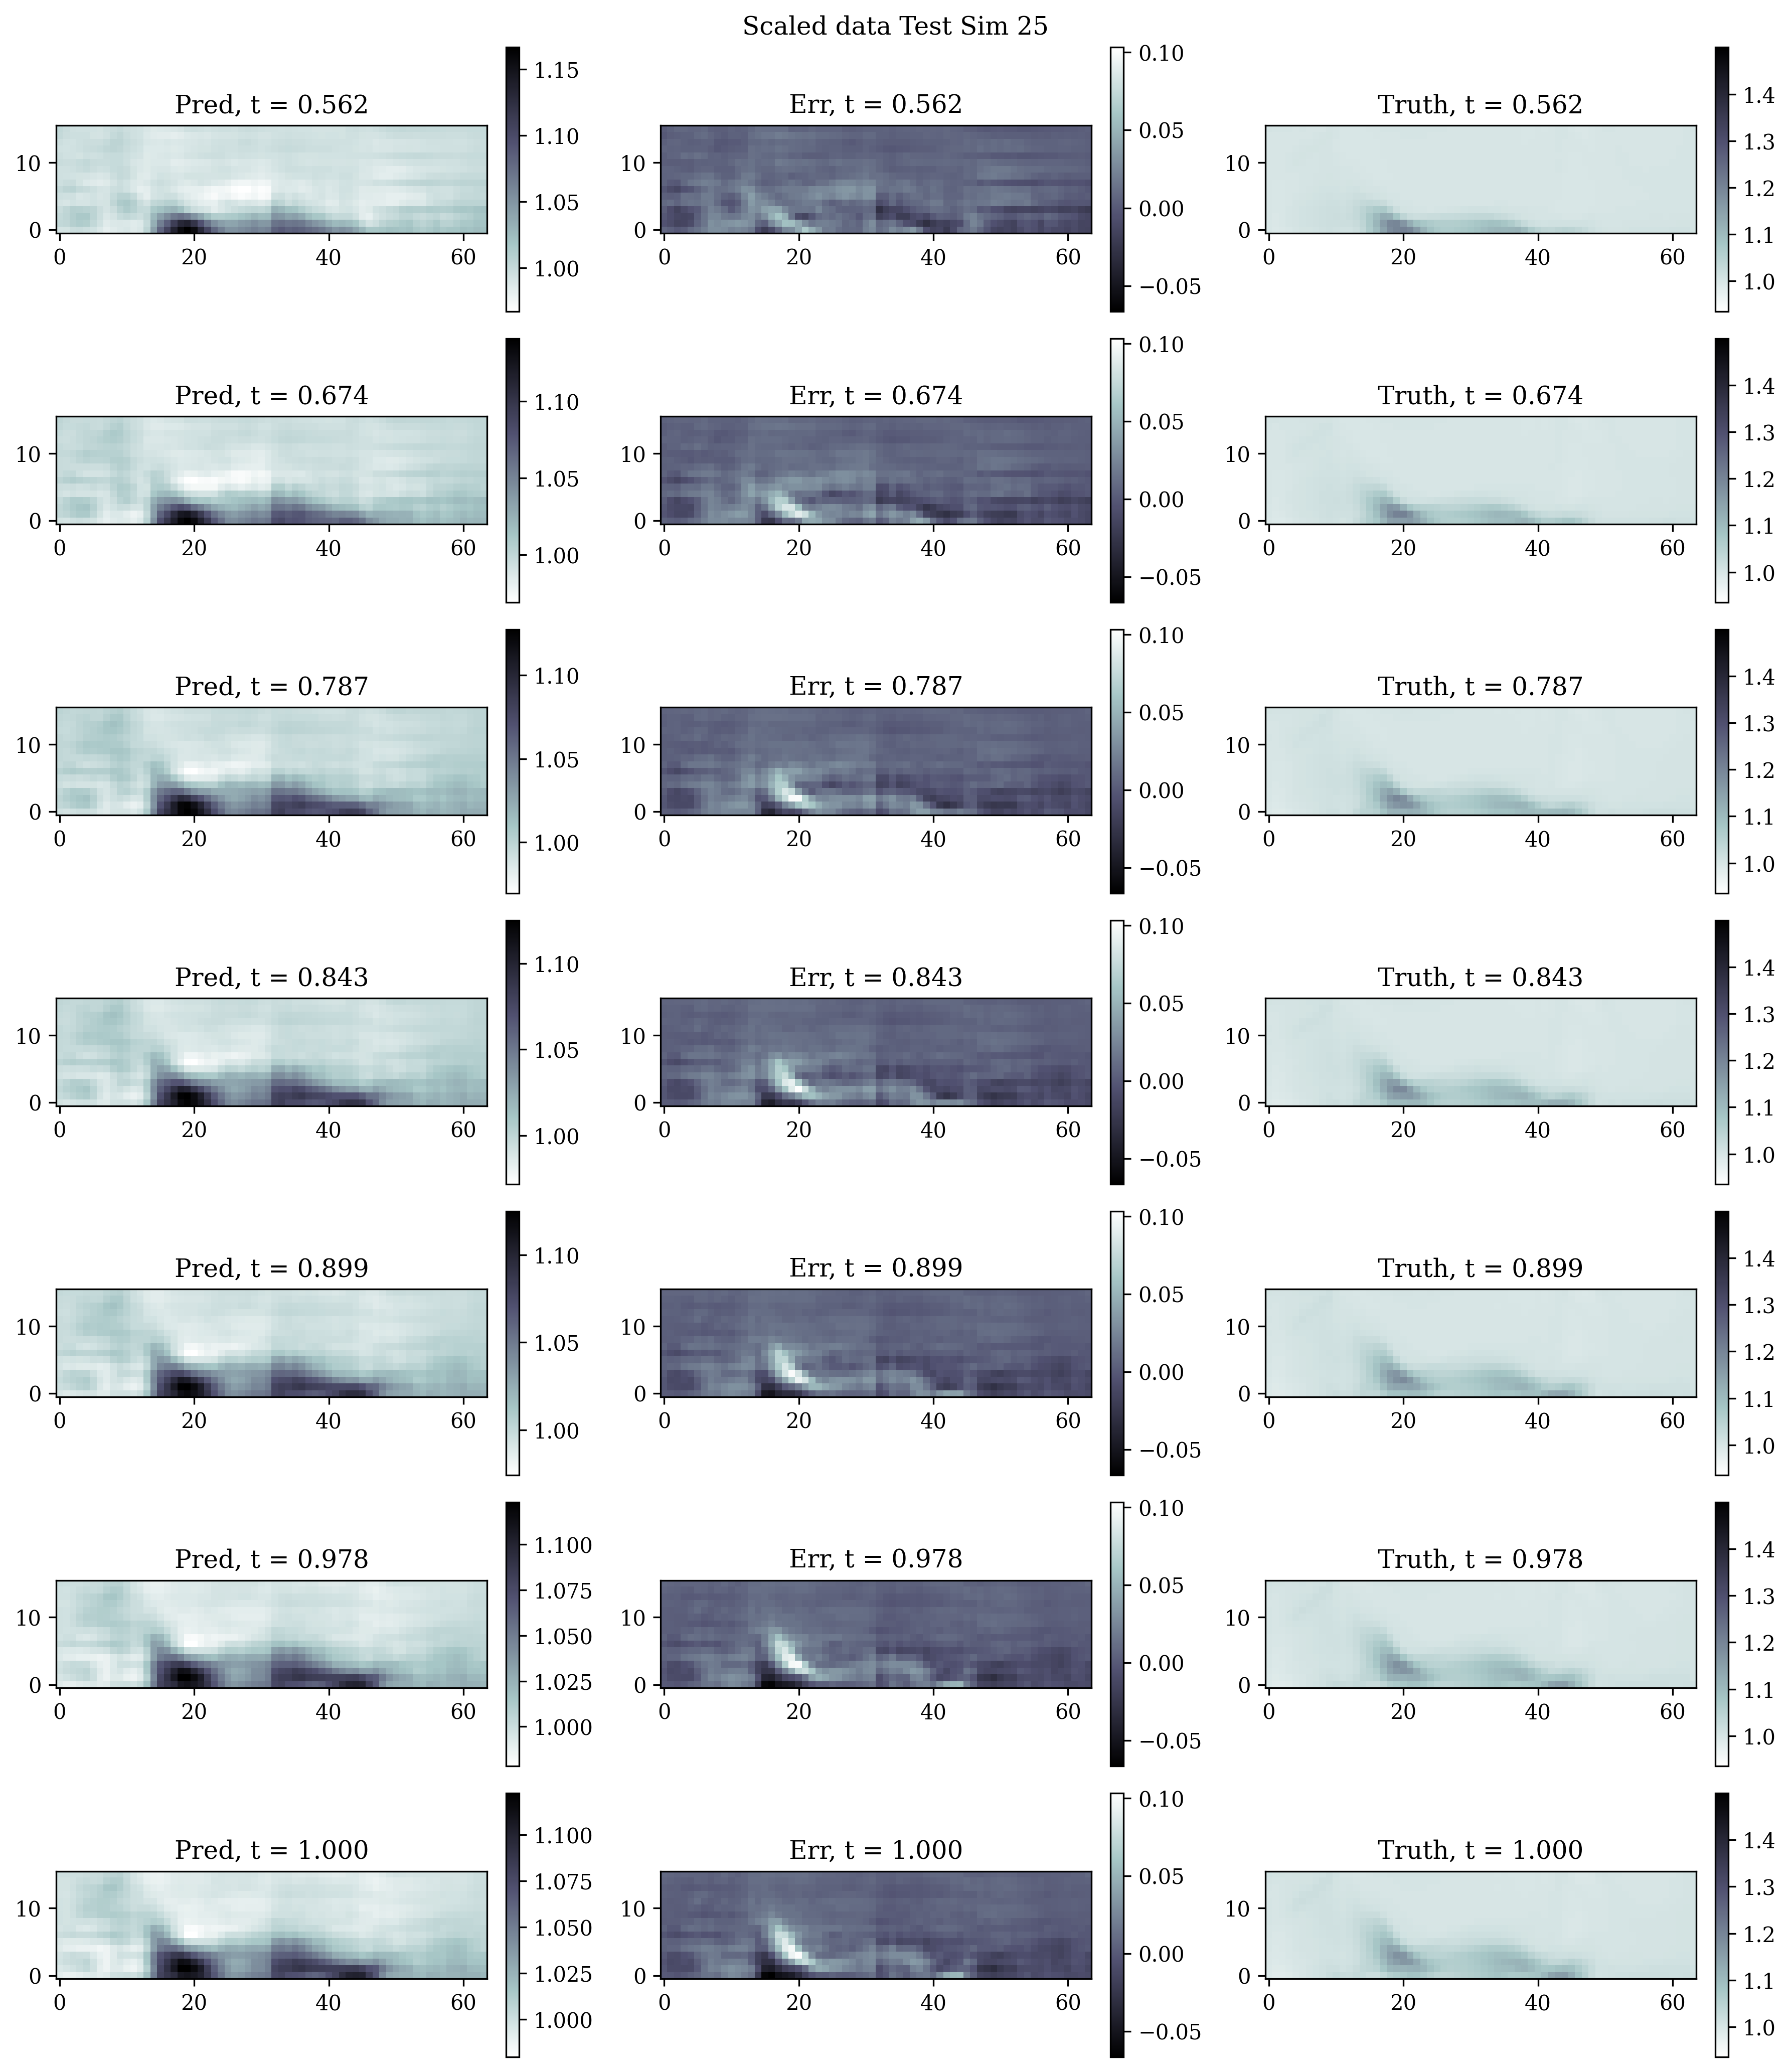

In [71]:
time_idx_to_plot = np.array([0, 10, 20, 25, 30, 37, 39])
sim_idx = 25

test_err_sim = test_target_rs[sim_idx, :, :, :] - test_pred_rs[sim_idx, :, :]
# print(test_err_sim.shape)

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(12, 14))

for row in range(7):
    im = axs[row, 0].imshow(medpy.filter.smoothing.anisotropic_diffusion(test_pred_rs[sim_idx, time_idx_to_plot[row], :, :]),
                           origin="lower",
                           cmap=lc3,
                           # vmin=trainMin,
                           # vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Pred, t = {:.3f}".format(tt_predictSim[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 1].imshow(test_err_sim[time_idx_to_plot[row], :, :],
                            origin="lower",
                            cmap=lc3_reg,
                            vmin=test_err_sim.min(),
                            vmax=test_err_sim.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Err, t = {:.3f}".format(tt_predictSim[time_idx_to_plot[row]]))
    
for row in range(7):
    im = axs[row, 2].imshow(test_target_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Truth, t = {:.3f}".format(tt_predictSim[time_idx_to_plot[row]]))

fig.suptitle("Scaled data Test Sim {}".format(sim_idx))
fig.tight_layout()

In [61]:
(1.4 - 1.15) / (1.4)

0.17857142857142858